In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torch.utils.data

In [2]:
torch.set_printoptions(linewidth=30)
torch.set_grad_enabled(True)

In [3]:
def get_correct_number(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, *input):
        input = F.relu(self.conv1(*input))
        input = F.max_pool2d(input, kernel_size=2, stride=2)

        input = F.relu(self.conv2(input))
        input = F.max_pool2d(input, kernel_size=2, stride=2)

        input = input.reshape(-1, 12*4*4)
        input = F.relu(self.fc1(input))

        input = F.relu(self.fc2(input))

        input = self.out(input)

        return input

In [5]:
train_data = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [6]:
network = Network()

data_loader = torch.utils.data.dataloader.DataLoader(train_data, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.001)

for epoch in range(5):
    total_loss = 0
    total_correct = 0

    for batch in data_loader:
        images, labels = batch

        preds = network(images)
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += get_correct_number(preds, labels)

    print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss)

epoch: 0 total_correct: 42714 loss: 455.6775531768799
epoch: 1 total_correct: 49075 loss: 291.076836258173
epoch: 2 total_correct: 50842 loss: 249.74585953354836
epoch: 3 total_correct: 51783 loss: 225.73086908459663
epoch: 4 total_correct: 52360 loss: 210.03227865695953


In [7]:
accuracy = total_correct / len(train_data)
print(accuracy)

0.8726666666666667


In [8]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

In [9]:
prediction_loader = torch.utils.data.DataLoader(train_data, batch_size=10000)
train_preds = get_all_preds(network, prediction_loader)

In [10]:
train_preds.shape

torch.Size([60000, 10])

In [11]:
print(train_preds.requires_grad)

True


In [12]:
train_preds.grad

In [13]:
train_preds.grad_fn

In [14]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_data, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

In [15]:
print(train_preds.requires_grad)

False


In [16]:
train_preds.grad

In [17]:
train_preds.grad_fn

In [18]:
preds_correct = get_correct_number(train_preds, train_data.targets)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_data))

total correct: 52604
accuracy: 0.8767333333333334


### Build a Confusion Matrix

In [19]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [20]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [21]:
stacked = torch.stack(
    (train_data.targets, train_preds.argmax(dim=1)), 
    dim=1
)

In [22]:
stacked.shape

torch.Size([60000, 2])

In [23]:
stacked

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [24]:
j, k = stacked[0].tolist()
j, k

(9, 9)

In [25]:
cmt = torch.zeros(10, 10, dtype=torch.int64)
cmt

tensor([[0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

In [26]:
for result in stacked:
    j, k = result.tolist()
    cmt[j, k] = cmt[j, k] + 1

In [27]:
cmt

tensor([[5442,    7,   54,
          134,   16,    1,
          286,    0,   59,
            1],
        [  18, 5812,    7,
          128,    7,    1,
           21,    0,    6,
            0],
        [ 145,    4, 4364,
           34,  897,    0,
          517,    0,   39,
            0],
        [ 350,   21,   12,
         5273,  206,    1,
          131,    0,    6,
            0],
        [  23,    6,  202,
          182, 5128,    0,
          443,    0,   15,
            1],
        [   1,    0,    0,
            1,    0, 5708,
            0,  164,   26,
          100],
        [1290,   10,  329,
          137,  602,    1,
         3559,    0,   72,
            0],
        [   0,    0,    0,
            0,    0,   61,
            0, 5707,   11,
          221],
        [  38,    1,   17,
           21,   27,   10,
           49,    6, 5826,
            5],
        [   0,    0,    1,
            1,    0,   22,
            0,  181,   10,
         5785]])

In [28]:
cmt.shape

torch.Size([10, 10])

### Plotting a Confusion Matrix

In [36]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import resources.plot_confusion_matrix as pcm

In [34]:
cm = confusion_matrix(train_data.targets, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[5442,    7,   54,  134,   16,    1,  286,    0,   59,    1],
       [  18, 5812,    7,  128,    7,    1,   21,    0,    6,    0],
       [ 145,    4, 4364,   34,  897,    0,  517,    0,   39,    0],
       [ 350,   21,   12, 5273,  206,    1,  131,    0,    6,    0],
       [  23,    6,  202,  182, 5128,    0,  443,    0,   15,    1],
       [   1,    0,    0,    1,    0, 5708,    0,  164,   26,  100],
       [1290,   10,  329,  137,  602,    1, 3559,    0,   72,    0],
       [   0,    0,    0,    0,    0,   61,    0, 5707,   11,  221],
       [  38,    1,   17,   21,   27,   10,   49,    6, 5826,    5],
       [   0,    0,    1,    1,    0,   22,    0,  181,   10, 5785]])

Confusion matrix, without normalization
[[5442    7   54  134   16    1  286    0   59    1]
 [  18 5812    7  128    7    1   21    0    6    0]
 [ 145    4 4364   34  897    0  517    0   39    0]
 [ 350   21   12 5273  206    1  131    0    6    0]
 [  23    6  202  182 5128    0  443    0   15    1]
 [   1    0    0    1    0 5708    0  164   26  100]
 [1290   10  329  137  602    1 3559    0   72    0]
 [   0    0    0    0    0   61    0 5707   11  221]
 [  38    1   17   21   27   10   49    6 5826    5]
 [   0    0    1    1    0   22    0  181   10 5785]]


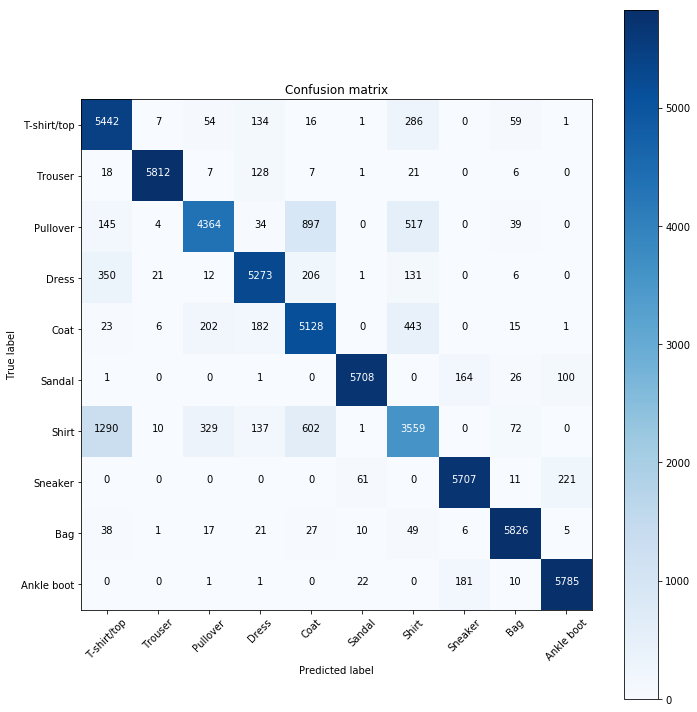

In [37]:
names = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

plt.figure(figsize=(10, 10))
pcm.plot_confusion_matrix(cm, names)